In [6]:
f0 = 3.5e6                 #  Transducer center frequency [Hz]
fs = 100e6                 #  Sampling frequency [Hz]
c = 1540                   #  Speed of sound [m/s]
lambd = c / f0             #  Wavelength [m]
width = lambd              #  Width of element
height = 5e-3              #  Height of element [m]
kerf = 0.05e-3             #  Kerf (gap between elements) [m]
pitch = kerf + width       #  Pitch (center-to-center distance between elements) [m]
num_elements = 192         #  Number of physical elements
num_sub_x = 5              #  Number of sub-divisions in x-direction of elements
num_sub_y = 5              #  Number of sub-divisions in y-direction of elements

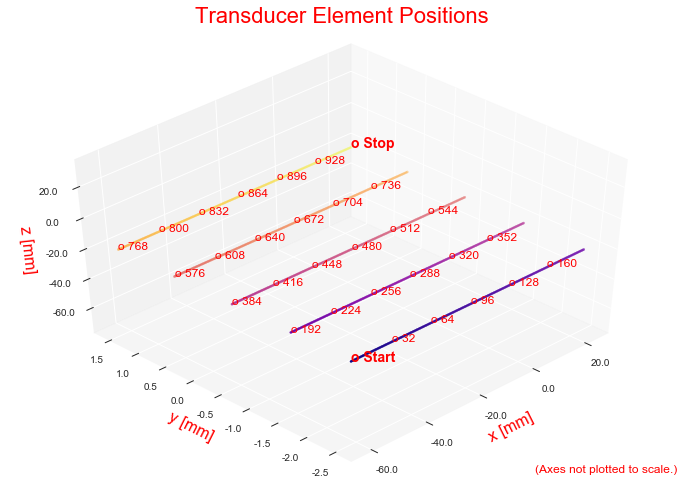

In [388]:
a=LinearTransducer (192, num_sub_y=5)
# a.plot (true_scale=1)
a.plot (true_scale=0)

In [384]:
import torch
import numpy as np

class Transducer:
    '''Base class for describing a transducer.'''
    
    def __init__ (self, num_elements=1, num_subelements=1,
                  x=None, y=None, z=None,
                  delay=None, apodization=None,
                  center_frequency=3.5e6,
                  dtype=torch.float32, device='cuda'):
        '''Use one of the subclasses to fill in the arguments of this constructor
        with calculated positions for a particular aperture geometry more easily.
        
        Ensures all tensors owned by the transducer have the same dtype and device,
        recorded in `self.tensor_type`.
        
        `num_elements` is the number of physical transducer elements.
        `num_subelements` is the number of logical elements used in the simulation
        (for better accuracy).
        `x`, `y`, `z` are the arrays of coordinate positions of each subelement given
        in meters (m).
        `delay` is an array of per-element delays (seconds).
        `apodization` is an array of per-element apodization factors (i.e. amplitude
        scaling factor applied to the signal transmitted/received at a given element).
        `center_frequency` is the frequency of the carrier wave used to transmit or
        demodulate the ultrasound signal for the transducer (Hz).
        `dtype` is the torch data type for all tensors owned by this Transducer.
        `device` is the string identifier passed to torch.device () to determine the
        device all tensors owned by this Transducer will be placed on.
        '''
        
        # Length of arrays
        self.num_elements = num_elements
        self.num_subelements = num_subelements
        self.num_subdivisions = num_subelements // num_elements
        
        # Center frequency
        self.center_frequency = center_frequency
        
        # Device and dtype
        self.dtype = dtype
        self.device = torch.device (device)
        self.tensor_type = torch.empty (0, dtype=self.dtype, device=self.device)
        
        # Positions of transducer subelements
        self.x = self.new_tensor (x)
        self.y = self.new_tensor (y)
        self.z = self.new_tensor (z)
        
        # Per-element delay and apodization
        self.delay = self.new_tensor (delay)
        self.apodization = self.new_tensor (apodization)
        
        self.check_shape (['x', 'y', 'z'], [num_subelements])
        self.check_shape (['delay', 'apodization'], [num_elements])
        
    def new_tensor (self, data, **kwargs):
        '''Call `torch.Tensor.new_tensor` with `self.tensor_type` as the reference tensor,
        or return `None` if `data` is `None`.'''
        if data is None:
            return None
        else:
            return self.tensor_type.new_tensor (data, **kwargs)
        
    def new_ones (self, size, **kwargs):
        '''Shortcut to calling `self.tensor_type.new_ones (...)`'''
        return self.tensor_type.new_ones (size, **kwargs)
    
    def new_zeros (self, size, **kwargs):
        '''Shortcut to calling `self.tensor_type.new_zeros (...)`'''
        return self.tensor_type.new_zeros (size, **kwargs)
    
    def check_shape (self, attributes, true_shape):
        '''Check that the list of `attributes` (given by their string names) have the desired `true_shape`.'''
        true_shape = tuple (true_shape)
        for attr in attributes:
            value = getattr (self, attr)
            if value is None:
                continue
            shape = tuple (value.shape)
            if shape != true_shape:
                msg = 'Shape of self.{} {} does not match desired true shape {}.'.format (attr, shape, true_shape)
                raise ValueError (msg)
    
    def same_tensor_type (self, other):
        return (self.tensor_type.dtype == other.tensor_type.dtype) and \
               (self.tensor_type.device == other.tensor_type.device)

    def __repr__ (self):
        '''Returns __repr__ of arguments needed to construct self.'''
        import inspect
        cls = type (self)
        constructor_args = inspect.signature (cls).parameters.keys ()
        message = cls.__name__ + ' ({})'
        # Note: `{{` escapes `{` and `}}` escapes `}`. (For reference: pyformat.info)
        template = ', '.join ('{0}={{{0}!r}}'.format (arg) for arg in constructor_args)
        
        return message.format (template).format (**self.__dict__)
    
class LinearTransducer (Transducer):
    '''A linear transducer.'''
    
    def __init__ (self, num_elements=1, width=.44e-3, height=5e-3, kerf=0, num_sub_x=1, num_sub_y=1,
                  center_frequency=3.5e6,
                  dtype=torch.float32, device='cuda'):
        '''Initializes an `Transducer` with a linear geometry spanning lengthwise the x-direction.
        Also initializes per-element delays and apodizations to 0s and 1s respectively.'''
        
        # Calculate sub-element positions
        x, y, z = self.linear_array (num_elements, width, height, kerf, num_sub_x, num_sub_y)

        # Initialize `Transducer`
        num_subelements = num_elements * num_sub_x * num_sub_y
        super ().__init__ (
            num_elements = num_elements,
            num_subelements = num_subelements,
            x = x.reshape (-1),
            y = y.reshape (-1),
            z = z.reshape (-1),
            center_frequency = center_frequency,
            dtype = dtype,
            device = device
        )
        
        # Default to delay=0, apodization=1 for all elements
        self.delay = self.new_zeros (num_elements),
        self.apodization = self.new_ones (num_elements)
        
        # Record number of subelement divisions
        self.num_sub_x = num_sub_x
        self.num_sub_y = num_sub_y
        
        # Keep element geometry
        self.width = width
        self.height = height
        self.kerf = kerf

    @classmethod
    def linear_array (cls, num_elements, width, height, kerf, num_sub_x=1, num_sub_y=1):
        '''Calculates the positions of elements in a linear array aperture (i.e. transducer).
        Arguments and functionality is very similar to xdc_linear_array() in Field II.'''
        
        # Subelement division offsets
        offset_x = cls.subdivide (width, num_sub_x)
        offset_y = cls.subdivide (height, num_sub_y)

        # Tile the subelement offsets
        tiled_offset_x = np.tile (offset_x, [num_sub_y, num_elements])
        tiled_offset_y = np.tile (offset_y.reshape(-1, 1), [1, tiled_offset_x.shape[1]])

        # Center-to-center distance between elements
        pitch = width + kerf
        
        # Tile the element positions
        position_x = np.arange ((-num_elements//2 + 1) * pitch, (num_elements//2 + 1) * pitch, pitch)
        position_x = position_x.reshape (1, -1)
        position_x = position_x.repeat (num_sub_x, axis=1)
        position_x = position_x.repeat (num_sub_y, axis=0)

        # Sum positions and offsets
        x = position_x + tiled_offset_x
        y = tiled_offset_y
        z = np.zeros (x.shape)
        
        return x, y, z
    
    @staticmethod
    def subdivide (length, num_divisions):
        '''Calculate a range of `num_divisions` positions centered around zero that have the given total `length`.'''
        step = length / num_divisions              # ex: step = 1
        start = (-num_divisions//2 + 1) * step     # ex: start = -3//2 + 1 = (-2) + 1 = -1
        stop = (num_divisions//2 + 1) * step       # ex: stop = 3//2 + 1 = (1) + 1 = 2 (but stop is excluded)
        divisions = np.arange (start, stop, step)  # ex: divisions = [-1, 0, 1]

        return divisions
    
    def plot (self, true_scale=False, show=True):
        '''Plot the aperture elements in 3D.'''
        from matplotlib import pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        # Size figure and make scatter plot.
        fig = plt.figure (figsize=(12,8))
        ax = fig.gca (projection='3d')
        ax.scatter (self.x, self.y, self.z, c=np.arange (self.num_subelements), s=5, cmap='plasma')
        
        if self.num_elements > 1:
            # Label first and last transducer element ('Start' and 'Stop').
            ax.text (self.x[0], self.y[0], self.z[0], 'o Start', fontsize=14, weight='bold', color='red')
            if true_scale:
                # Scale axes to true proportions (if `true_scale` set).
                limits = np.array ([getattr (ax, 'get_{}lim'.format(axis)) () for axis in 'xyz'])
                ax.auto_scale_xyz(*[(limits.min (), limits.max ())]*3)
            else:
                # Label transducer elements.
                stride = self.num_elements * self.num_sub_x // 6
                stride = max (stride, 1)
                for i in range (stride, self.num_subelements, stride):
                    ax.text (self.x[i], self.y[i], self.z[i], 'o {}'.format (i), fontsize=12, color='red')
                # Warn that axes are not to scale.
                ax.text2D (1, 0, '(Axes not plotted to scale.)', transform=ax.transAxes,
                           ha='right', fontsize=12, color='red')
            ax.text (self.x[-1], self.y[-1], self.z[-1], 'o Stop', fontsize=14, weight='bold', color='red')
        else:
            # Special case when there's only one element
            ax.scatter (self.x, self.y, self.z, c='red', s=50)

        # Label axes and convert tick values to millimeters.
        ax.set_xlabel ('x [mm]', color='red', fontsize=16, labelpad=10)
        xticks = ax.get_xticks ()
        ax.set_xticklabels (['{:.1f}'.format (e*1000) for e in xticks])
        ax.set_ylabel ('y [mm]', color='red', fontsize=16, labelpad=10)
        yticks = ax.get_yticks ()
        ax.set_yticklabels (['{:.1f}'.format (e*1000) for e in yticks])
        ax.set_zlabel ('z [mm]', color='red', fontsize=16, labelpad=10)
        zticks = ax.get_zticks ()
        ax.set_zticklabels (['{:.1f}'.format (e*1000) for e in zticks])

        # Give the plot a title
        ax.set_title ('Transducer Element Positions', color='red', fontsize=22, pad=50)
        
        # Set the background color and view angle
        ax.set_facecolor ('white')
        ax.view_init (elev=45, azim=225)

        if show:
            plt.show()
        else:
            return fig, ax


In [368]:
import torch

class Simulation:
    '''Data and parameters needed to run a simulation.'''
    
    def __init__ (self, sampling_frequency=100e6, decimation=10,
                  center_frequency=3.5e6, attenuation=.7,
                  scan_depth=9e-2, speed_of_sound=1540,
                  transmitter=Transducer (), receiver=None):
        '''The value of `sampling_frequency / decimation` tells how many
        samples to record per a second of simulation (Hz).
        
        `center_frequency` (Hz) describes the carrier wave frequency of the `transmitter`
        transducer.
        `attenuation` is the decrease in amplitude of the signal over distance travelled in dB/MHz/cm.
        `scan_depth` is how deep into the tissue (m) to simulate.
        `speed_of_sound` is the uniform speed assumed to be constant throughout the tissue (m/s).
        `transmitter` and `receiver` are `Transducer` instances (possibly the same instance) that
        describe the element geometry and delay/apodization settings of the transducer(s) used to
        transmit and receive the ultrasound signal.

        `receiver` defaults to the same instance as `transmitter` if not given.

        The `tensor_type` attribute (specifying the dtype and device of all tensors owned) of the
        transmitter and receiver must be the same.
        '''
        
        # Store parameters given.
        self.sampling_frequency = sampling_frequency
        self.decimation = decimation
        self.center_frequency = center_frequency
        self.attenuation = attenuation
        self.scan_depth = scan_depth
        self.speed_of_sound = speed_of_sound
        
        # Compute number of time samples needed.
        self.num_time_samples = self.compute_time_samples (self.scan_depth, self.speed_of_sound,
                                                           self.sampling_frequency)
        
        # Save transducers.
        self.transmitter = transmitter
        self.receiver = (receiver) if (receiver is not None) else (transmitter)
        
        # Check that the transducers have the same `tensor_type`.
        if not self.transmitter.same_tensor_type (self.receiver):
            msg = 'Transmitter and receiver `Transducer` instances must have the ' \
                  'same tensor_type (i.e. dtype and device).'
            msg += '\nTransmitter tensor_type:  {}'.format (self.transmitter.tensor_type)
            msg += '\nReceiver tensor_type:     {}'.format (self.receiver.tensor_type)
            raise ValueError (msg)
        
        # Bind these tensor constructors for convenience.
        self.new_tensor = transmitter.new_tensor
        self.new_ones = transmitter.new_ones
        self.new_zeros = transmitter.new_zeros
            
    def load_field_ii_scatterers (filepath):
        '''Load scatterer data from a *.mat file from a Field II example.
        Save the data as `self.scatterer_x`, `self.scatterer_y`, `self.scatterer_z`,
        `self.scatterer_amplitude`.'''
        import scipy.io as spio
        mat = spio.loadmat (filepath)
        pos, amp = mat['phantom_positions'], mat['phantom_amplitudes']
        self.scatter_x = self.new_tensor (pos[:,0])
        self.scatter_y = self.new_tensor (pos[:,1])
        self.scatter_z = self.new_tensor (pos[:,2])
        self.scatter_amplitude = self.new_tensor (amp.reshape (-1))
        self.num_scatterers = self.scatter_x.nelement ()
        
    def set_gaussian_excitation (self, bw=.5, bwr=-6, plot=True):
        '''Define the ultrasound excitation signal.
        `bw` is the fractional bandwidth (between 0 and 1) of the Gaussian modulating
        signal relative to the transmitter center frequency.
        `bwr` is the reference level at which the fractional bandwidth is calculated (dB).
        (See scipy.signal.gausspulse.)'''
        
        from scipy.signal import gausspulse
        import matplotlib.pyplot as plt

        fc = self.transmitter.center_frequency
        fs = self.sampling_frequency
        
        # https://github.com/scipy/scipy/blob/14142ff70d84a6ce74044a27919c850e893648f7/scipy/signal/waveforms.py#L232
        # exp(-a t^2) <->  sqrt(pi/a) exp(-pi^2/a * f^2)  = g(f)
        bwr = -6
        pi = np.pi
        ref = pow (10.0, bwr / 20.0)
        a = -(np.pi * fc * bw) ** 2 / (4.0 * np.log (ref))
        time_sigma = 1/np.sqrt (2*a)
        time = np.arange (-3*time_sigma, 3*time_sigma, 1/fs)
        
        if plot:
            # Plot the excitation signal
            excitation, envelope  = gausspulse(time, fc=fc, bw=bw, bwr=bwr, retenv=True)
            plt.plot(envelope, 'g--', excitation)
            plt.title ('Excitation Signal', fontsize=20, pad=20)
            plt.xlabel ('Time [$\mu$s]', fontsize=14, labelpad=10)
            plt.gca ().set_facecolor ('white')
            xticks = plt.xticks ()[0]
            plt.gca ().set_xticklabels (['{:.2f}'.format (i*1e6/fs) for i in xticks])
            plt.grid (False, axis='y')
            plt.grid (True, axis='x', linestyle=':', color='gray')
            plt.yticks ([])
            plt.show ()
        else:
            excitation  = gausspulse(time, fc=fc, bw=bw, bwr=bwr)
        
        # Set the excitation signal
        self.excitation = self.new_tensor (excitation)
        
    @staticmethod
    def compute_time_samples (scan_depth, speed_of_sound, sampling_frequency):
        return 2 * scan_depth / speed_of_sound * sampling_frequency
    
    def run_simulation (self):
        '''
        import projection_kernel
        
        projection_kernel.run ()
        '''
    
    def __repr__ (self):
        '''Returns __repr__ of arguments needed to construct self.'''
        import inspect
        cls = type (self)
        constructor_args = inspect.signature (cls).parameters.keys ()
        message = cls.__name__ + ' ({})'
        # Note: `{{` escapes `{` and `}}` escapes `}`. (For reference: pyformat.info)
        template = ', '.join ('{0}={{{0}!r}}'.format (arg) for arg in constructor_args)
        
        return message.format (template).format (**self.__dict__)


In [363]:
Simulation ()

Simulation (sampling_frequency=100000000.0, decimation=10, center_frequency=3500000.0, attenuation=0.7, scan_depth=0.09, speed_of_sound=1540, transmitter=Transducer (num_elements=1, num_subelements=1, x=None, y=None, z=None, delay=None, apodization=None, center_frequency=3500000.0, dtype=torch.float32, device=device(type='cuda')), receiver=Transducer (num_elements=1, num_subelements=1, x=None, y=None, z=None, delay=None, apodization=None, center_frequency=3500000.0, dtype=torch.float32, device=device(type='cuda')))

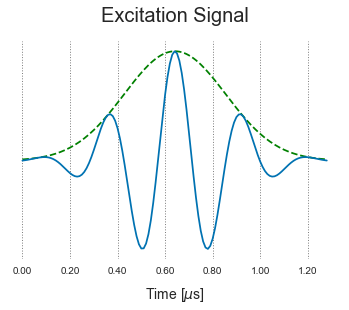

In [367]:
Simulation (transmitter=Transducer ()).set_gaussian_excitation ()

In [359]:
Simulation().__dict__

{'sampling_frequency': 100000000.0,
 'center_frequency': 3500000.0,
 'attenuation': 0.7,
 'scan_depth': 0.09,
 'speed_of_sound': 1540,
 'num_time_samples': 11688.311688311687,
 'transmitter': Transducer (num_elements=1, num_subelements=1, x=None, y=None, z=None, delay=None, apodization=None, center_frequency=3500000.0, dtype=torch.float32, device=device(type='cuda')),
 'receiver': Transducer (num_elements=1, num_subelements=1, x=None, y=None, z=None, delay=None, apodization=None, center_frequency=3500000.0, dtype=torch.float32, device=device(type='cuda')),
 'new_tensor': <bound method Transducer.new_tensor of Transducer (num_elements=1, num_subelements=1, x=None, y=None, z=None, delay=None, apodization=None, center_frequency=3500000.0, dtype=torch.float32, device=device(type='cuda'))>,
 'new_ones': <bound method Transducer.new_ones of Transducer (num_elements=1, num_subelements=1, x=None, y=None, z=None, delay=None, apodization=None, center_frequency=3500000.0, dtype=torch.float32, dev

In [160]:
file = r'C:\Users\spenc\Desktop\Experiments\ftp_files\cyst_phantom\pht_data.mat'



Help on class Simulation in module __main__:

class Simulation(builtins.object)
 |  Data and parameters needed to run a simulation.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sampling_frequency=100000000.0, decimation=10, center_frequency=3500000.0, scan_depth=0.09, speed_of_sound=1540, transmitter=None, receiver=None)
 |      The value of `sampling_frequency / decimation` tells how many
 |      samples to record per a second of simulation (Hz).
 |      
 |      The `center_frequency` (Hz) describes the carrier wave transmission frequency of the
 |      transducer.
 |      
 |      `scan_depth` is how deep into the tissue (m) to simulate.
 |      
 |      `speed_of_sound` is the uniform speed assumed to be constant throughout the tissue (m/s).
 |      
 |      `transmitter` and `receiver` are `Transducer` instances (possibly the same instance) that
 |      describe the element geometry and delay/apodization settings of the transducer(s) used to
 |      transmit and receive 